In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/bitcoin2015to2017.csv'
Generating dummy data...


<ipython-input-6-a3b56e432030>:60: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2020-01-01', periods=1000, freq='H')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - loss: 0.2019 - val_loss: 0.0897
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0817 - val_loss: 0.0210
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0216 - val_loss: 0.0021
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0113 - val_loss: 0.0034
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0107 - val_loss: 0.0023
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0099 - val_loss: 0.0019
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0081 - val_loss: 0.0026
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/ste

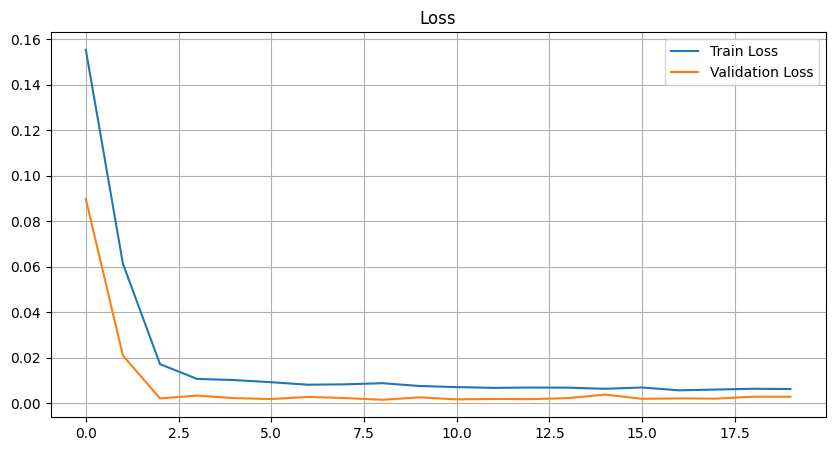

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
RMSE Min: 10.41
MAE Min: 8.76
RMSE Max: 12.02
MAE Max: 9.91
Up Guesses: 3, Correct: 3 (100.00%)
Down Guesses: 8, Correct: 8 (100.00%)


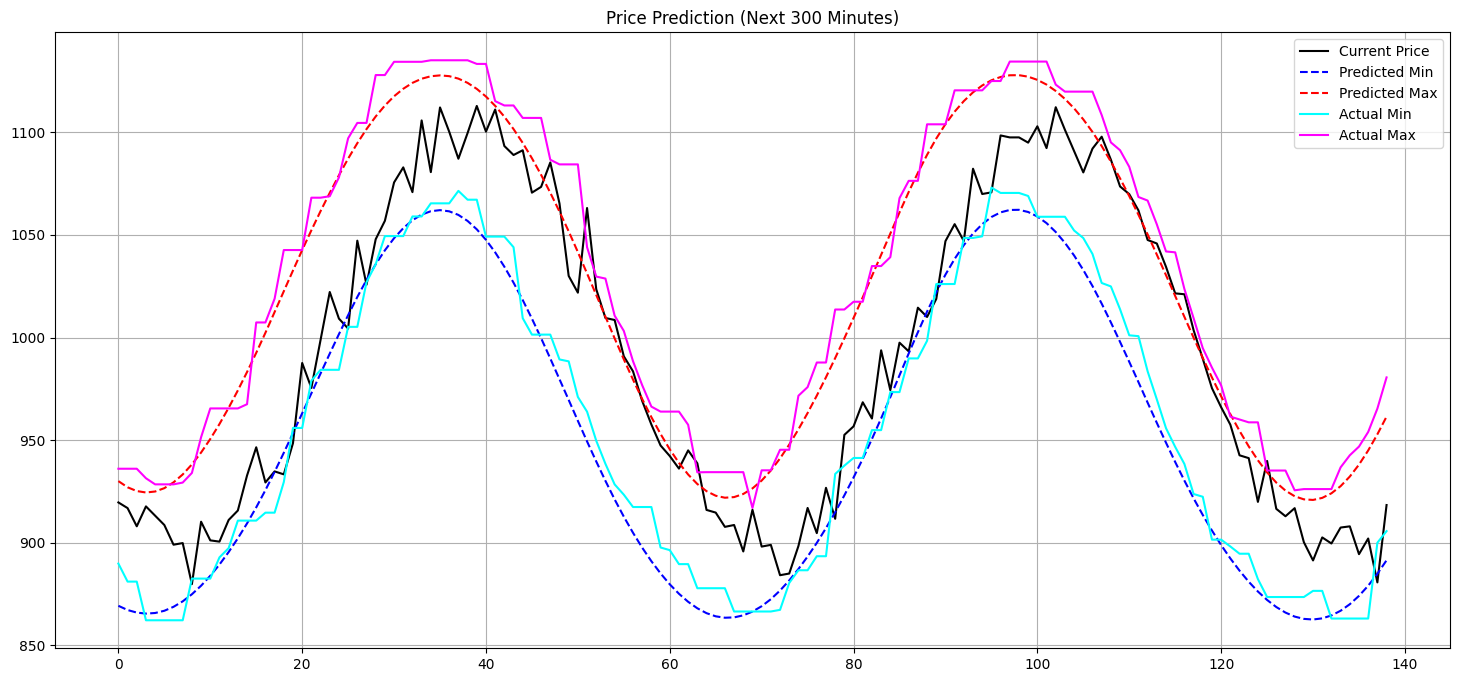

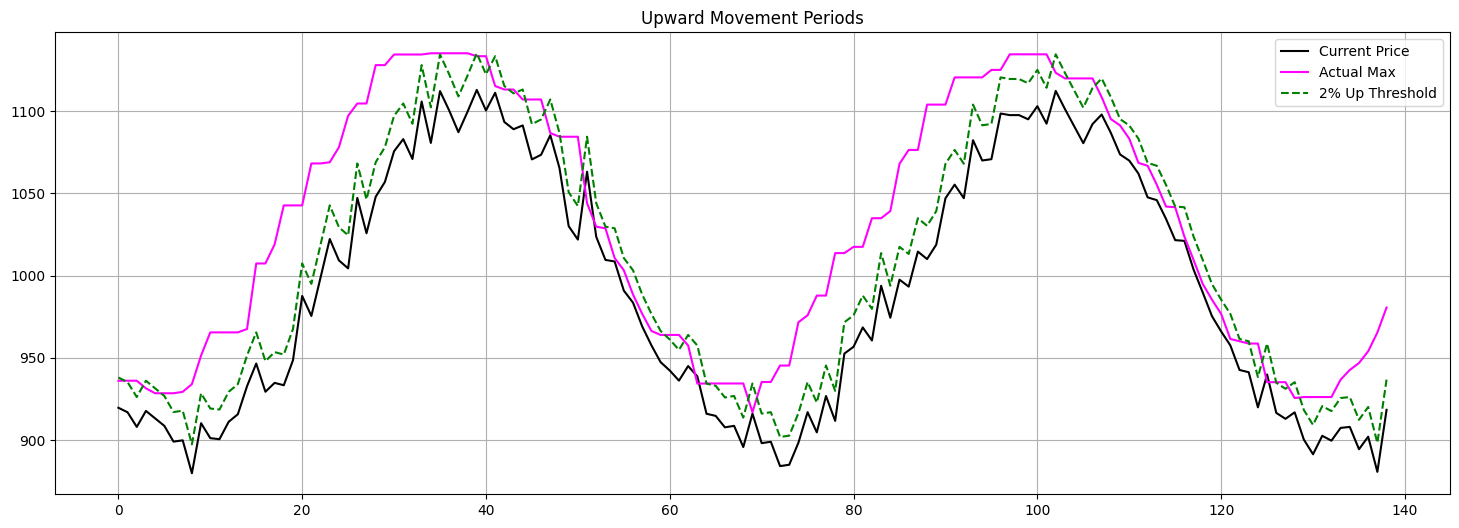

In [6]:
# =======================
# Install and Import Packages
# =======================
!pip install tensorflow

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# =======================
# Mount Google Drive and Load CSV
# =======================
from google.colab import drive
drive.mount('/content/drive')

# Path to your uploaded CSV in Google Drive
file_path = '/content/drive/MyDrive/bitcoin2015to2017.csv'

# =======================
# Helper: Create Sequences
# =======================
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# =======================
# Load and Prepare Data
# =======================
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")
    print("Columns in CSV:", df.columns)

    # Try to detect datetime column
    datetime_cols = ['Timestamp', 'timestamp', 'Date', 'date', 'Datetime', 'datetime']
    datetime_found = False

    for col in datetime_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df.set_index(col, inplace=True)
            datetime_found = True
            break

    if not datetime_found:
        raise Exception("Missing timestamp column.")

except Exception as e:
    print(f"Error: {e}")
    print("Generating dummy data...")
    dates = pd.date_range(start='2020-01-01', periods=1000, freq='H')
    close = np.sin(np.linspace(0, 100, 1000)) * 100 + 1000 + np.random.randn(1000) * 10
    df = pd.DataFrame({'Date': dates, 'Close': close, 'Low': close * 0.98, 'High': close * 1.02})
    df.set_index('Date', inplace=True)

# =======================
# Preprocess Data
# =======================
if not all(col in df.columns for col in ['Close', 'Low', 'High']):
    raise ValueError("Missing required columns: Close, Low, High")

data = df[['Close', 'Low', 'High']].dropna()

# Predict 300 minutes (5 hours) into the future
prediction_window_minutes = 300
freq = pd.infer_freq(data.index)
periods_in_window = 5

if freq:
    if 'min' in freq:
        min_interval = int(''.join(filter(str.isdigit, freq)))
        periods_in_window = prediction_window_minutes // min_interval
    elif 'H' in freq:
        periods_in_window = prediction_window_minutes // 60

data['Future_Min'] = data['Low'].rolling(window=periods_in_window, closed='right').min().shift(-periods_in_window)
data['Future_Max'] = data['High'].rolling(window=periods_in_window, closed='right').max().shift(-periods_in_window)
data.dropna(inplace=True)

# =======================
# Normalize and Sequence
# =======================
X_raw = data[['Close']].values
y_raw = data[['Future_Min', 'Future_Max']].values

train_size = int(len(X_raw) * 0.8)
X_train_raw, X_test_raw = X_raw[:train_size], X_raw[train_size:]
y_train_raw, y_test_raw = y_raw[:train_size], y_raw[train_size:]

scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(np.hstack([X_raw, y_raw]))
X_scaled = scaled_all[:, 0].reshape(-1, 1)
y_scaled = scaled_all[:, 1:]

X_train_scaled, X_test_scaled = X_scaled[:train_size], X_scaled[train_size:]
y_train_scaled, y_test_scaled = y_scaled[:train_size], y_scaled[train_size:]

seq_length = 60
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

# =======================
# Build and Train Model
# =======================
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(2)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# =======================
# Evaluate Model
# =======================
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title("Loss"); plt.grid(); plt.show()

predictions_scaled = model.predict(X_test_seq)
dummy_close = np.zeros((predictions_scaled.shape[0], 1))
pred_combined = np.hstack((dummy_close, predictions_scaled))
pred_original = scaler.inverse_transform(pred_combined)

actual_combined = np.hstack((dummy_close, y_test_seq))
actual_original = scaler.inverse_transform(actual_combined)

pred_min, pred_max = pred_original[:, 1], pred_original[:, 2]
actual_min, actual_max = actual_original[:, 1], actual_original[:, 2]
current_price_test = X_raw[train_size + seq_length:].flatten()

# =======================
# Metrics
# =======================
print(f"RMSE Min: {np.sqrt(mean_squared_error(actual_min, pred_min)):.2f}")
print(f"MAE Min: {mean_absolute_error(actual_min, pred_min):.2f}")
print(f"RMSE Max: {np.sqrt(mean_squared_error(actual_max, pred_max)):.2f}")
print(f"MAE Max: {mean_absolute_error(actual_max, pred_max):.2f}")

# =======================
# Strategy: Guess Up/Down
# =======================
guess_up = guess_down = correct_up = correct_down = 0

for i in range(len(current_price_test)):
    cp = current_price_test[i]
    pmn = pred_min[i]
    pmx = pred_max[i]
    amn = actual_min[i]
    amx = actual_max[i]

    if pmn > cp * 1.005:
        guess_up += 1
        if amx > cp:
            correct_up += 1
    elif pmx < cp * 0.995:
        guess_down += 1
        if amn < cp:
            correct_down += 1

print(f"Up Guesses: {guess_up}, Correct: {correct_up} ({correct_up/guess_up*100:.2f}%)" if guess_up else "No Up Guesses")
print(f"Down Guesses: {guess_down}, Correct: {correct_down} ({correct_down/guess_down*100:.2f}%)" if guess_down else "No Down Guesses")

# =======================
# Visualize Predictions
# =======================
plt.figure(figsize=(18, 8))
plt.plot(current_price_test, label='Current Price', color='black')
plt.plot(pred_min, label='Predicted Min', linestyle='--', color='blue')
plt.plot(pred_max, label='Predicted Max', linestyle='--', color='red')
plt.plot(actual_min, label='Actual Min', color='cyan')
plt.plot(actual_max, label='Actual Max', color='magenta')
plt.title("Price Prediction (Next 300 Minutes)")
plt.legend(); plt.grid(); plt.show()

# =======================
# Plot Upward Thresholds
# =======================
plt.figure(figsize=(18, 6))
up_thresh = current_price_test * 1.02
plt.plot(current_price_test, label='Current Price', color='black')
plt.plot(actual_max, label='Actual Max', color='magenta')
plt.plot(up_thresh, label='2% Up Threshold', linestyle='--', color='green')
plt.title("Upward Movement Periods")
plt.legend(); plt.grid(); plt.show()
